$$
\newcommand{\M}{\mathcal{M}}
\newcommand{\y}{\mathbf{y}}
\newcommand{\yhat}{\mathbf{\hat{y}}}
\newcommand{\iou}{\textbf{IOU}}
$$

<aside>
💡 Consider changing resume next time to Yolo version because I will likely code out this algorithm from scratch rather than RCNN. In fact, we did use Yolo a bit?

</aside>

- Elaboration on LTA project - check my overleaf.
    - Data Preparation
        - 500 readily provided photos from LTA, the positive samples were not a lot, and since we are allowed to take our own photos, we can solve this imbalanced issue by taking more photos around SG. We can also solve imbalanced issue by:
            - First, check if we can collect more data for the minority class, this may not always be feasible, but worth a try to ask first.
            - Make sure the metrics defined for such problem is sensible, for example, using accuracy is not good and one should explain why this is the case by using the `ZeroR` example. One should also mention that AUROC, precision-recall metrics that are not so misleading. **But in object detection be careful as AUROC is not used since no FN.**
            - Over/Under sampling: delete majority class randomly till convergence to desired distribution, or resample with replacement minority class.
            - Smote
        - Metrics
            - Mention of AUROC, PR-Curve and why Accuracy is not ideal.
            - But mention Average Precision as more relevant.
        - Augmentation techniques. This helps artificially expanding the dataset, intuition is in each training iteration (batch), the model sees a slightly different version of the original image, and thus helps to generalize.
            - Normal flips and rotational geometrical transformation, that is a given since photos can be upside down, left-right flipped.
            - Hue, Saturation and Color to match dusk, noon and dawn.
            - Random Eraser, similar to dropout, we mask certain parts of the image to force the model to learn with less information, a regularization to overfitting and memorization.
    - Object Detection: a 2 staged process where we first **localize** the object of interest, then **classify** the object. i.e. an input image with a cat and dog, we need to know where these 2 animals are, parametrized by bounding boxes coordinates, and also classify them correctly.

## Data Collection and Label

### Original Dataset

- 500 images of size $4032 \times 3024$ provided by LTA:
    - 150 positive class 1 where 1 means defective;
    - 350 negative class 0 where 0 means non-defective;
    - Class labels are subjected to changes depending on model used (i.e. F-RCNN treats background as 0 while Yolo does not care)

- There is some slight class imbalance:
    - We checked if we can garner more data;
    - We were given the green light;
    - We collected about 1500 more photos.

### Labelling

- The total number of images is $2000$;
- We need to label all of them as labels were not provided;
- Shortage of manpower prompted us to think of ways to reduce manual labour.

#### Semi-Supervised Learning

> **Semi-supervised learning is an approach to machine learning that combines a small amount of labeled data with a large amount of unlabeled data during training. Semi-supervised learning falls between unsupervised learning (with no labeled training data) and supervised learning (with only labeled training data). It is a special instance of weak supervision.**

**High-level overview**

- We manually labour $500$ images of 50-50 ratio with class balanced;
- We train on the $500$ images using an Object Detection Model $\M_1$ until convergence (i.e. an acceptable result say MAP > 0.8, but more importantly, we **do not care** the class accuracy, rather, we want the localization error to be low);
- We use $\M_1$ and perform inference on the remaining $1500$ images so that $\M_1$ can return us each image's bounding box coordinates, during this process we can discard bounding boxes with low confidences if we feel that an image won't contain more than say, 5 tactile tiles;
- Note that we emphasized on a low localization error from $\M_1$ and therefore expect that at the very least the bounding boxes of the tactile tiles are accurate as drawing bounding boxes manually is more time consuming than labelling whether a given bounding box is of class 0 or 1;
- We then run through manually over the predicted $1500$ images to see if the predicted bounding boxes by $\M_1$ makes sense, and also to correct them if need be.

## Establish Metrics

After understanding the problem better, we should probably define a metric to optimize. We adopt the commonly used metrics for object detection.

### IOU

The concept of **Intersection over Union (IOU)**, also known as the **Jaccard Index** is used to decide whether the predicted bounding box is giving us a good outcome. 

It is defined by the formula: $$J(A,B) = \dfrac{|(A \cap B)|}{|(A \cup B)|}$$

where A and B are the area of the ground truth bounding box and predicted ground truth bounding box respectively as shown in figure below.

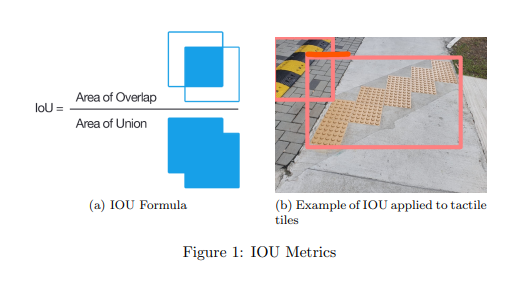

### The Typical Brothers (TP, FP, TN, FN)

Object Detection at its core is a complicated algorithm comprising of both regression and classification. We first define the 4 good brothers that we see in a typical **classification problem**.

Note in usual classification problem, we will have a probabality logit at the end of a softmax/sigmoid layer, which aids us in determining whether a classification belongs to TP, FP, TN or FN.
In object detection, we use the **IOU** to determine if a given a bounding box prediction belongs to the four brothers.

Let us define:

- $\y$: 1 single ground truth bbox;
- $\yhat$: 1 single predicted bbox;
- $\iou(\y, \yhat)$: The IOU between them.
- $t$: The threshold for IOU to cross for it to be a positive, defaults to $0.5$.

Then:

- TP: The model classified it as positive and it indeed is positive; $\yhat$ is TP iff $\iou(\y, \yhat) > t$; both the predictor and the ground truth are in agreement;
- FP: The model classified it as positive but it is negative; $\yhat$ is FP iff $\iou(\y, \yhat) < t$; the predictor raised a false alarm that there is an object but there actually isn't;
- FN: The model classified it as negative but it is positive; $\yhat$ is FN iff there exists a ground truth $\y$ that is not detected by our model;
- TN: This is usually ignored since it means that both the predictor and the annotator ground truth did not have a bounding box; it is often termed as **correct rejections** because there exist infinite places on an image where there are no bounding boxes from both the predictor and the annotator.

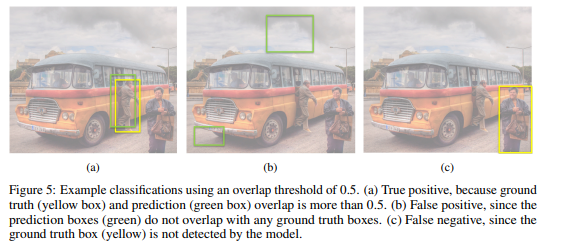

### The Iconic DUO (Precision and Recall)

As with any other classification problem, we will see this iconic duo. Let us recap these 2 metrics in the settings of object detection.

### Precision

> **Precision measures how many of the samples predicted as positive are actually positive. Mathematically, it is expressed as:**

$$
\text{Precision} = \dfrac{\text{TP}}{\text{TP} + \text{FP}}=P(Y=1 | \hat{Y} = 1)
$$

---

> A Probablistic Interpretation
    Notice that the above definition has a probabilitic interpretation $P(Y = 1 | \hat{Y} = 1)$, where $Y$ and $\hat{Y}$ refers to the actual label and predicted labels respectively. We interpreted precision and recall not as ratios but as [estimations of probabilities](https://en.wikipedia.org/wiki/Precision_and_recall).
    Precision is then the estimated probability that a random point selected from the samples are positive. This might be a tough pill to swallow as someone who was never good in statistics but it is just conditional probability. If you try to think a bit further, you can form an intuition as follows:
    > If your classifier $h$ is trained and the last layer is say, sigmoid, which in binary classification, calibrates the logits and turn them into probabilities. Then it can be interpretated that given a randomly chosen point $x \in X_{train}$, what is the probability of this point $x$ to be positive given that it is predicted as positive by the classifer?

---

Informally, precision answers the question **what proportion of positive predictions was actually correct**? In other words, out of all the positive predictions made by the model, how many of those positive predictions were actually positive when compared to the ground truth?

> **In object detection, precision can be throught of as the fraction of correct object predictions among all objects detected by the model**

### Recall

> **Recall measures the following: out of all the actual positives (say, the real cancer patients), how many of them were identified correctly by the classifier? Mathematically, it is expressed as:**
    
$$
\text{Recall}= \dfrac{\text{TP}}{\text{TP} + \text{FN}}= P(\hat{Y}=1 | Y = 1)=1-FNR
$$

From the formula, we see the denominator to be defined as TP + FN, which is unsurprising as this gives you the actual number of positives. The dynamics is also similar to the one in precision.

> **In object detection, recall can be thought of as the fraction of ground truth objects that are correctly detected by the model.**

### Recall vs Precision

The tug of war between this duo is still present, that is to say, as precision goes down, recall might go up and vice versa.

Note that precision and recall are parametrized by the IOU threshold $t$, that means, for each threshold $t$, we can calculate the pair of precision and recall score.

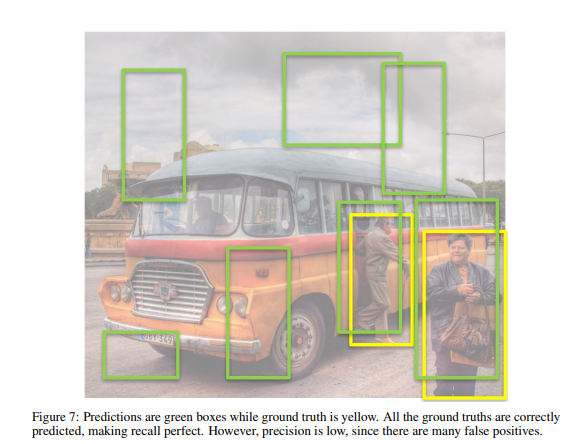

### The Objectness Confidence Score

Before we proceed to the behemoth **Mean Average Precision**, we should take a step back and recall that an usual object detection model is parametrized by:

- predicted bbox: [[...], [...]] 2 predictions;
- associated objectness confidence score: [0.2, 0.9] how confident that the predicted bbox really do contains an object;
- predicted labels: [1, 2]
- associated labels confidence score: [0.3, 0.8] how confident that the predicted label is correct, usually this is the probability logits.

Before we even get to IOU calculation, we have another threshold to worry about, which is the objectness confidence score $\tau$; that is, if the predicted bboxes has confidence score below $\tau$, then we immediately discard the predictions and do not even consider it a valid prediction. So if you are have a high $\tau$ threshold, then you may have a high precision at the cost of low recall. Let us breakdown why:

- If you raise $\tau$, then we have a stringent requirement such that more objects might be missed by the model. A high FN ensues.
- If you decrease $\tau$, then we may have many predictions, say a ground truth image has 2 gt bbox, but since we loosen $\tau$, we have 10 predicted bboxes, this causes a lot of FPs.

> **So a precision recall curve is a plot of precision vs recall at various thresholds $\tau$. Note very carefully that the pr-curve is parametrized by $\tau$ and not $t$ (the IOU threshold).**

### Average Precision

> **The big picture, precison-recall curve can be understood as y = f(x) where y is precision and recall x. More simply, it is just plotting pairs of precision-recall for each threshold $\tau$ and summing the area under the curve.**